
🔍 Forecasting TSLA from 2015 to 2025...


[*********************100%***********************]  1 of 1 completed
C:\Users\User\gmf-time-series-forecasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


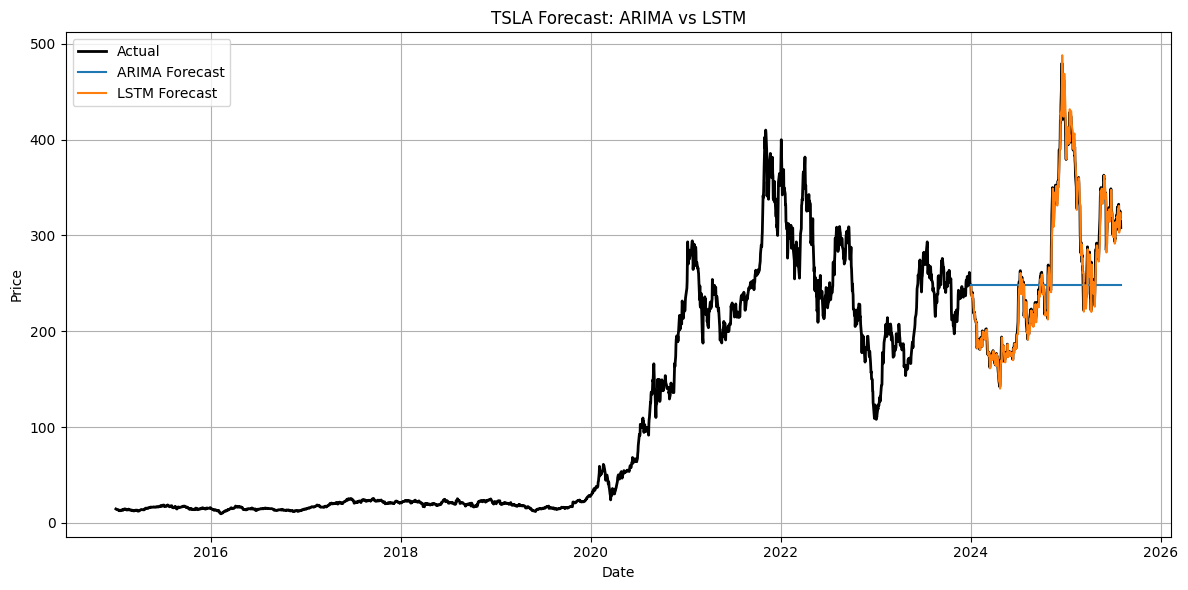


📋 Evaluation Metrics for TSLA:
ARIMA:
  RMSE: 77.9225
  MAE: 62.9615
  MAPE: 0.2408
LSTM:
  RMSE: 11.7123
  MAPE: 3.1032


In [ ]:
# Edited commit
import sys, os, warnings
project_root = os.path.abspath("..")
sys.path.insert(0, project_root)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd

from src.forecasting.arima_model import train_arima, forecast_arima, evaluate_arima
from src.forecasting.lstm_model import build_lstm_model, train_lstm
from src.forecasting.data_loader import load_tsla_data, scale_data
from src.forecasting.plot_forecast import plot_forecasts

def calculate_rmse(actual, predicted):
    actual = np.asarray(actual).flatten()
    predicted = np.asarray(predicted).flatten()
    return np.sqrt(np.mean((actual - predicted) ** 2))

def calculate_mape(actual, predicted):
    actual = np.asarray(actual).flatten()
    predicted = np.asarray(predicted).flatten()
    return np.mean(np.abs((actual - predicted) / actual)) * 100

def run_forecasting_pipeline():
    print("\n🔍 Forecasting TSLA from 2015 to 2025...")

    tsla, train, test = load_tsla_data()
    scaler, train_scaled, test_scaled = scale_data(train, test)

    # ARIMA
    arima_model = train_arima(train)
    arima_forecast = forecast_arima(arima_model, steps=len(test))
    arima_metrics = evaluate_arima(test, arima_forecast)

    # LSTM
    X_train = train_scaled[:-1]
    y_train = train_scaled[1:]
    X_test = test_scaled[:-1]

    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    lstm_model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    trained_model = train_lstm(lstm_model, X_train, y_train)

    lstm_forecast_scaled = trained_model.predict(X_test)
    lstm_forecast = scaler.inverse_transform(lstm_forecast_scaled).flatten()

    aligned_test = test[-len(lstm_forecast):].values.flatten()
    lstm_metrics = {
        "RMSE": calculate_rmse(aligned_test, lstm_forecast),
        "MAPE": calculate_mape(aligned_test, lstm_forecast)
    }

    forecasts = {
        "ARIMA": arima_forecast,
        "LSTM": lstm_forecast
    }
    plot_forecasts(tsla, forecasts, title="TSLA Forecast: ARIMA vs LSTM")

    print("\n📋 Evaluation Metrics for TSLA:")
    for model_name, metrics in [("ARIMA", arima_metrics), ("LSTM", lstm_metrics)]:
        print(f"{model_name}:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.4f}")

run_forecasting_pipeline()
